In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import cv2
import os
import gc

In [4]:
print(os.listdir("/content/drive/MyDrive/SmartBridge/Ship Classification/input"))

['train.csv', 'test_ApKoW4T.csv', 'train', 'images', 'test']


In [5]:
path = "/content/drive/MyDrive/SmartBridge/Ship Classification/input/train/images"
train_files = pd.read_csv('/content/drive/MyDrive/SmartBridge/Ship Classification/input/train.csv', dtype={'image': 'object', 'category': 'int8'})
test_files = pd.read_csv('/content/drive/MyDrive/SmartBridge/Ship Classification/input/test_ApKoW4T.csv')

In [6]:
train_files.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [7]:
test_files.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [8]:
train_files[train_files.isnull().any(axis=1)]

,image,category


In [10]:
ship = {1:'Cargo', 
        2:'Military', 
        3:'Carrier', 
        4:'Cruise', 
        5:'Tankers'}

# reverse the ship type dictionary
#ship = dict([[v,k] for k,v in ship.items()])

In [11]:
train_files['ship'] = train_files['category'].map(ship).astype('category')
labels = list(train_files['ship'].unique())

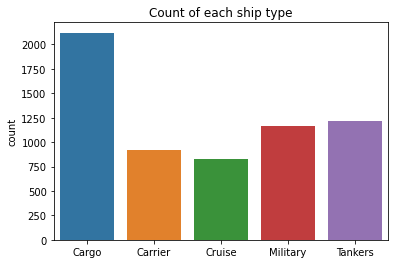

2592

In [12]:
plt.title('Count of each ship type')
sb.countplot(x=train_files['ship'].values)
plt.show()
gc.collect()

In [15]:
train_files['ship'].value_counts()

Cargo       2120
Tankers     1217
Military    1167
Carrier      916
Cruise       832
Name: ship, dtype: int64

In [14]:
train_files['ship'].value_counts(normalize=True)

Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: ship, dtype: float64

In [ ]:
# labels = train_files.sort_values('ship')
# class_names = list(labels.ship.unique())
# for i in class_names:
#     os.makedirs(os.path.join('/content/drive/MyDrive/SmartBridge/Ship Classification/input/train',i))


In [ ]:
# labels

In [ ]:
# import shutil
# for c in class_names: # Category Name
#   for i in list(labels[labels['ship']==c]['image']): # Image Id
#     get_image = os.path.join('/content/drive/MyDrive/SmartBridge/Ship Classification/input/images/', i) # Path to Images
#     move_image_to_cat = shutil.move(get_image, '/content/drive/MyDrive/SmartBridge/Ship Classification/input/train/'+c)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input

In [19]:
train_datagen = ImageDataGenerator(rotation_range=45, 
                             horizontal_flip=True, 
                             width_shift_range=0.5, 
                             height_shift_range=0.5, 
                             validation_split=0.2,
                             preprocessing_function=preprocess_input
                             )

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [20]:
train_set = train_datagen.flow_from_directory( '/content/drive/MyDrive/SmartBridge/Ship Classification/input/train/',
                               batch_size=16, subset='training',
                               target_size=(224,224))

validation_set = train_datagen.flow_from_directory('/content/drive/MyDrive/SmartBridge/Ship Classification/input/train/',
                                                        batch_size=16, subset='validation',
                                                        target_size=(224,224)
                                                      )


test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/SmartBridge/Ship Classification/input/test',batch_size=16,
                                            target_size=(224,224))

Found 5003 images belonging to 5 classes.
Found 1249 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [21]:
from keras.layers import Dense,Flatten, Dropout
from keras.models import Model

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=5

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
cp = ModelCheckpoint('best.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

In [ ]:
epochs = 25
history = vgg_model.fit_generator(generator=train_set, 
                              steps_per_epoch=train_set.n//train_set.batch_size, 
                              validation_steps = validation_set.n//validation_set.batch_size,
                              validation_data=validation_set, 
                              callbacks=[cp],
                              epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/25
312/312 [==============================] - ETA: 0s - loss: 6.7383 - accuracy: 0.5183
Epoch 1: val_loss improved from inf to 0.95033, saving model to best.hdf5
312/312 [==============================] - 2318s 7s/step - loss: 6.7383 - accuracy: 0.5183 - val_loss: 0.9503 - val_accuracy: 0.6314
Epoch 2/25
312/312 [==============================] - ETA: 0s - loss: 0.9575 - accuracy: 0.6489
Epoch 2: val_loss improved from 0.95033 to 0.80836, saving model to best.hdf5
312/312 [==============================] - 102s 328ms/step - loss: 0.9575 - accuracy: 0.6489 - val_loss: 0.8084 - val_accuracy: 0.6955
Epoch 3/25
312/312 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.6870
Epoch 3: val_loss did not improve from 0.80836
312/312 [==============================] - 99s 318ms/step - loss: 0.8142 - accuracy: 0.6870 - val_loss: 0.8554 - val_accuracy: 0.6891
Epoch 4/25
312/312 [==============================] - ETA: 0s - loss: 0.8158 - accuracy: 0.6894
Epoch 4: val_lo

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b'], title=''):
    ax.plot(x, vy, 'b', label='Validation Loss')
    ax.plot(x, ty, 'r', label='Train Loss')
    plt.legend()
    plt.grid()
    plt.title(title)
    fig.canvas.draw()
    plt.show()
    gc.collect()

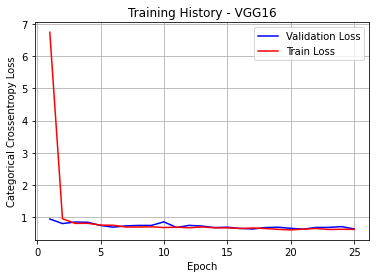

In [ ]:
fig, ax = plt.subplots(1,1)
vy = history.history['val_loss']
ty = history.history['loss']
ax.set_xlabel('Epoch')
x = list(range(1,epochs+1))
ax.set_ylabel('Categorical Crossentropy Loss')
plt_dynamic(x,vy,ty,ax, title='Training History - VGG16')

In [ ]:
vgg_model.save('vgg16-ship-classification.h5')